<a href="https://colab.research.google.com/github/Sanjiro1202/Clustering/blob/main/Modelo_de_Segmentaci%C3%B3n_de_Clientes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Revisión del conjunto de datos**

In [ ]:
# Librerías para visualizar, modificar y acceder a los datos
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from google.colab import drive

In [ ]:
# Accediendo a drive para manejar los datos
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Visualizando el dataframe
df = pd.read_excel(r"/content/drive/MyDrive/Colab Notebooks/Datos/base_prueba_tecnica.xlsx")
df = df.set_index("ID")
df.head()

,Edad,Genero,Ingresos Anuales,Gasto Mensual,Puntuación de Crédito,Región,Comportamiento en linea,Compras en el ultimo año
ID,,,,,,,,
1,21,Masculino,222011,2297,335,Sur,8,81
2,26,Masculino,239229,3420,329,Oeste,10,27
3,38,Masculino,716278,36965,711,Oeste,9,82
4,64,Femenino,697325,9846,855,Sur,2,6
5,52,Femenino,1032569,6607,989,Sur,3,2


In [ ]:
df.dtypes # Las columnas estan categorizadas correctamente

Edad                         int64
Genero                      object
Ingresos Anuales             int64
Gasto Mensual                int64
Puntuación de Crédito        int64
Región                      object
Comportamiento en linea      int64
Compras en el ultimo año     int64
dtype: object

In [ ]:
# No hay valores nulos
valores_nulos = df.isnull()
numero_valores_nulos = valores_nulos.sum()
numero_valores_nulos

Edad                        0
Genero                      0
Ingresos Anuales            0
Gasto Mensual               0
Puntuación de Crédito       0
Región                      0
Comportamiento en linea     0
Compras en el ultimo año    0
dtype: int64

In [ ]:
# Los datos se encuentran dentro del rango de valores esperados
print(f'Rango de Edad: { df["Edad"].min() } - { df["Edad"].max() }')
print(f'Puntuación de Crédito: { df["Puntuación de Crédito"].min() } - { df["Puntuación de Crédito"].max() }')
print(f'Comportamiento en linea: { df["Comportamiento en linea"].min() } - { df["Comportamiento en linea"].max() }')

Rango de Edad: 18 - 70
Puntuación de Crédito: 300 - 999
Comportamiento en linea: 1 - 10


# **2. Relación entre variables y elección de características**

Como idea inicial y de acuerdo a la información proporcionada, se tomará el puntaje crediticio como la característica que varia con respecto a las demás. A continuación se puede observar, de acuerdo a las gráficas, que Edad es la única característica relacionada por completo con Puntuación de Crédito, pero Gasto Mensual e Ingresos Anuales tienen cierta relación hasta alcanzar valores cercanos a los 800 puntos en puntaje crediticio,  después de este umbral, difieren. Las columnas Comportamiento y Compras en el último año, practicamente no tienen nada en común a la columna a evaluar.

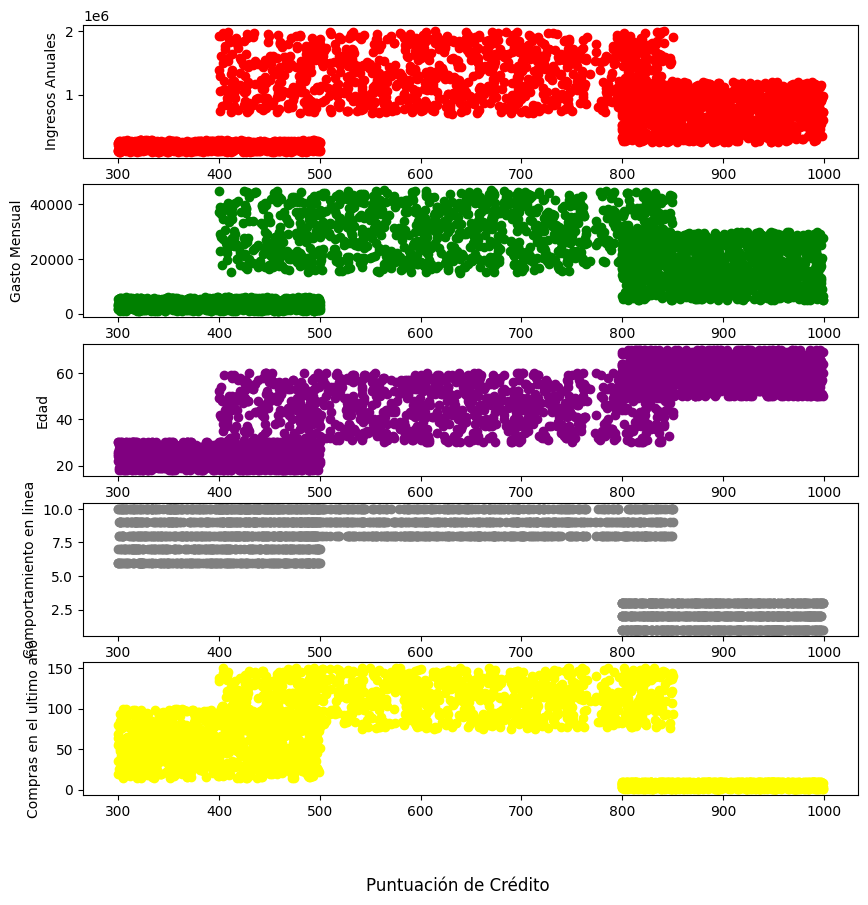

In [ ]:
# Se busca una relación de variables con respecto a la puntuación de crédito, ya que es la característica que se va a categorizar.
fig, ax = plt.subplots(5, 1, figsize=(10,10), alpha= 0.8)
fig.supxlabel("Puntuación de Crédito")
x = df["Puntuación de Crédito"]
y_axis = ["Ingresos Anuales", "Gasto Mensual","Edad","Comportamiento en linea","Compras en el ultimo año"]
colors = ['red','green','purple','gray','yellow']

for i in range(5):
  ax[i].scatter(x, y=df[y_axis[i]], color = colors[i])
  ax[i].set_ylabel(y_axis[i])

Para confirmar será necesario aplicar la función corr de pandas para confirmar la relación entre las variables. Dependiendo de la distribución de los datos se utilizará el coeficiente de Pearson, Spearman o Kendall. Para estar seguros, se realizará un análisis tanto gráfico como númerico para cada uno de los datos, con el fin de determinar si tienen o no una distribución normal.

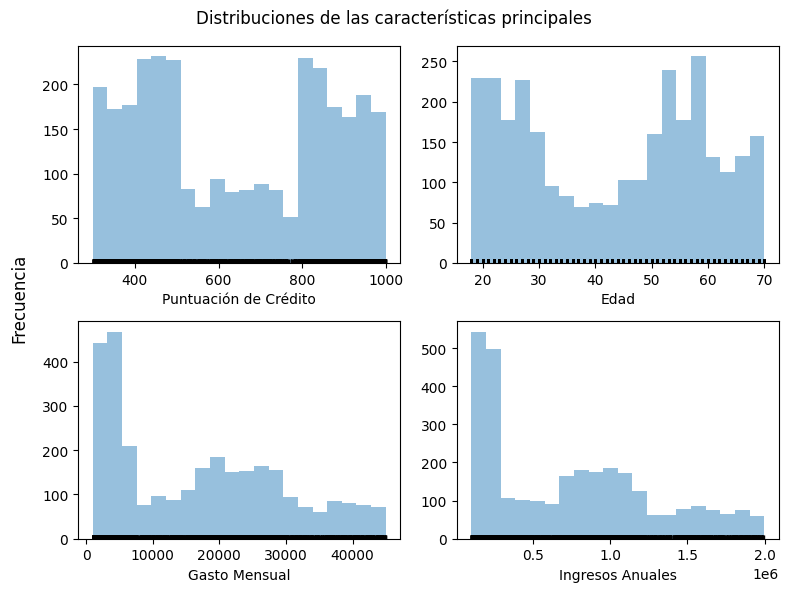

In [ ]:
# Gráfica con las distribuciones de cada variable
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
fig.suptitle("Distribuciones de las características principales")
fig.supylabel("Frecuencia")
x_axis_matrix = [["Puntuación de Crédito","Edad"],["Gasto Mensual","Ingresos Anuales"]]

for i in range(2):
  for j in range(2):
    axs[i][j].hist(x=df[x_axis_matrix[i][j]], bins=20, color="#3182bd", alpha=0.5)
    axs[i][j].plot(df[x_axis_matrix[i][j]], np.full_like(df[x_axis_matrix[i][j]], -0.01), '|k', markeredgewidth=1)
    axs[i][j].set_xlabel(x_axis_matrix[i][j])

plt.tight_layout();

De acuerdo al valor estándar alpha que es equivalente a 0.05, es posible afirmar que, con respecto a p-value para cada columna en la preuba de Shapiro, ninguna pertenece a una distribución normal puesto que dicho valor es menor a ese umbral, por lo que se tienen suficientes evidencias para rechazar esa posibilidad

In [ ]:
# Normalidad de los residuos Shapiro-Wilk test
caracteristicas = ["Puntuación de Crédito","Edad","Gasto Mensual","Ingresos Anuales"]

for variable in caracteristicas:
  shapiro_test = stats.shapiro(df[variable])
  print(f"Variable {variable}: {shapiro_test}")

Variable Puntuación de Crédito: ShapiroResult(statistic=0.9102842807769775, pvalue=6.726355943023983e-39)
Variable Edad: ShapiroResult(statistic=0.9217997789382935, pvalue=6.49618605612988e-37)
Variable Gasto Mensual: ShapiroResult(statistic=0.9161814451217651, pvalue=6.560872123216779e-38)
Variable Ingresos Anuales: ShapiroResult(statistic=0.9091023802757263, pvalue=4.323597110394006e-39)


El p_value de la prueba de D'Agostino se interpreta de la misma forma como se hizo en la prueba anterior. Por lo tanto podemos afirmar de forma definitiva que ninguna de las gráficas tiene una distribución normal, por lo que descartamos el uso del método Pearson para hallar la correlación entre variables.

In [ ]:
# Normalidad de los residuos D'Agostino's K-squared test
for variable in caracteristicas:
  k2, p_value = stats.normaltest(df[variable])
  print(f"Variable {variable}: Estadístico = {k2}, p-value = {p_value}")

Variable Puntuación de Crédito: Estadístico = 19002.33420705756, p-value = 0.0
Variable Edad: Estadístico = 26494.377631484414, p-value = 0.0
Variable Gasto Mensual: Estadístico = 767.1145730363268, p-value = 2.64964060975918e-167
Variable Ingresos Anuales: Estadístico = 401.2738694160959, p-value = 7.319583851199004e-88


Como se observa, las variables superan el umbral de 0, lo que significa que existe algo de correlación entre ellas, por lo que se usarán estas 4 características para entrenar el algoritmo de clúster en la siguiente sección.

In [ ]:
# Por último se calcula la correlación con los métodos de Spearman y Kendall
def mostrarCorrelacion(variable1, variable2):
  print(f"{variable1.name} vs. {variable2.name}")
  print('Correlación Spearman: ', variable1.corr(variable2, method='spearman'))
  print('Correlación Kendall: ', variable1.corr(variable2, method='kendall'))


mostrarCorrelacion(df['Edad'], df['Puntuación de Crédito'])
mostrarCorrelacion(df['Ingresos Anuales'], df['Gasto Mensual'])
mostrarCorrelacion(df['Gasto Mensual'], df['Puntuación de Crédito'])
mostrarCorrelacion(df['Ingresos Anuales'], df['Puntuación de Crédito'])

Edad vs. Puntuación de Crédito
Correlación Spearman:  0.8120861831468428
Correlación Kendall:  0.5972556531679533
Ingresos Anuales vs. Gasto Mensual
Correlación Spearman:  0.7848318540914371
Correlación Kendall:  0.5622991725592869
Gasto Mensual vs. Puntuación de Crédito
Correlación Spearman:  0.465610940402775
Correlación Kendall:  0.2639468741179794
Ingresos Anuales vs. Puntuación de Crédito
Correlación Spearman:  0.4593432327105997
Correlación Kendall:  0.25899658423234234


# **3. Creación del algoritmo de clúster**

Como se observó en las gráficas de dispersión, los datos estaban agrupados en tres conjuntos, por lo cuál, es una buena opción establecer 3 categorias para clasificar a las personas de acuerdo a su puntaje crediticio. No hay un estándar del rango de puntajes a usar en Colombia, por lo que se usarán rangos manejados por los modelos FICO y VantageScore (usados en Estados Unidos) adaptados a nuestras necesidades.

In [ ]:
#Rangos originales:

"""def clasificarPuntajeCrediticio(puntaje):
  if puntaje < 580:
    return 0 #Pobre
  elif puntaje < 670:
    return 1 #Regular
  elif puntaje < 740:
    return 2 #Bueno
  elif puntaje < 800:
    return 3 #Muy Bueno
  elif puntaje <= 999:
    return 4 #Excelente"""

def clasificarPuntajeCrediticio(puntaje):
  if puntaje < 580:
    return 0 # Pobre
  elif puntaje < 740:
    return 1 # Bueno y Regular
  elif puntaje <=999:
    return 2 # Muy Bueno y Excelente

df["Clasificacion de Credito"] = [clasificarPuntajeCrediticio(i) for i in df["Puntuación de Crédito"]]
df.tail()

,Edad,Genero,Ingresos Anuales,Gasto Mensual,Puntuación de Crédito,Región,Comportamiento en linea,Compras en el ultimo año,Clasificacion de Credito
ID,,,,,,,,,
2996,31,Masculino,1724725,25756,792,Sur,10,83,2
2997,46,Masculino,1683667,29508,504,Oeste,10,81,0
2998,26,Masculino,193267,5940,421,Este,7,45,0
2999,21,Femenino,106725,1762,440,Norte,7,89,0
3000,21,Femenino,152149,5562,405,Sur,8,28,0


In [ ]:
# Se crea un nuevo dataframe con las variables importantes para la realización del clúster
df_correlacionado = df.drop(['Genero','Región','Comportamiento en linea','Compras en el ultimo año'], axis=1)
df_correlacionado

,Edad,Ingresos Anuales,Gasto Mensual,Puntuación de Crédito,Clasificacion de Credito
ID,,,,,
1,21,222011,2297,335,0
2,26,239229,3420,329,0
3,38,716278,36965,711,1
4,64,697325,9846,855,2
5,52,1032569,6607,989,2
...,...,...,...,...,...
2996,31,1724725,25756,792,2
2997,46,1683667,29508,504,0
2998,26,193267,5940,421,0


In [ ]:
# Estandarización de los datos
from sklearn import preprocessing
df_normalizado = preprocessing.RobustScaler().fit_transform(df_correlacionado)

clasificacion_normalizada = np.array([array[4] for array in df_normalizado])

df_normalizado = np.array([np.delete(x, 4) for x in df_normalizado])

df_normalizado

array([[-8.33333333e-01, -5.64607499e-01, -6.45891706e-01,
        -7.07021792e-01],
       [-6.66666667e-01, -5.44968065e-01, -5.94728809e-01,
        -7.21549637e-01],
       [-2.66666667e-01, -8.29811151e-04,  9.33552017e-01,
         2.03389831e-01],
       ...,
       [-6.66666667e-01, -5.97393880e-01, -4.79919816e-01,
        -4.98789346e-01],
       [-8.33333333e-01, -6.96106617e-01, -6.70265837e-01,
        -4.52784504e-01],
       [-8.33333333e-01, -6.44294464e-01, -4.97141165e-01,
        -5.37530266e-01]])

In [ ]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(df_normalizado, clasificacion_normalizada, random_state=0, stratify = clasificacion_normalizada)

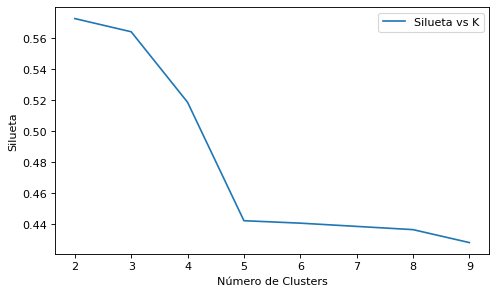

In [ ]:
# Coeficiente de Silueta
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
siluetas = []
for i in range(2, 10):
    km = KMeans(n_clusters=i,n_init=10, init='k-means++', max_iter=300, tol=1e-04, random_state=1)
    km.fit(Xtrain)
    silueta = metrics.silhouette_score(Xtrain,km.labels_,metric="euclidean")
    siluetas.append(silueta)

plt.figure(figsize=(7, 4), dpi=80)
plt.plot(range(2,10), siluetas, label="Silueta vs K")
plt.xlabel("Número de Clusters")
plt.ylabel("Silueta")
plt.legend(loc='upper right')
plt.show()

In [ ]:
#Centroides generados por el algoritmo cluster de acuerdo a las 4 características usadas
kmeans = KMeans(n_init=10,n_clusters=3,random_state=0).fit(Xtrain)
kmeans.cluster_centers_

array([[-0.73753915, -0.60287579, -0.59074077, -0.55008531],
       [-0.02467949,  0.72604671,  0.64834232, -0.01030053],
       [ 0.45345345,  0.00964034,  0.03701465,  0.6374614 ]])

In [ ]:
# Se utiliza el modelo de predicción Kmeans
predicted_kmean = kmeans.predict(Xtest)

# Se reemplazan los datos estandarizados por los originales
ytest[ytest == 0.] = 1
ytest[ytest == -0.5] = 0
ytest[ytest == 0.5] = 2

# **4. Evaluación y visualización del modelo**

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

# Se utilizan distintas medidas de evaluación para comprobar la efectividad del modelo:

print("Evaluation report KMeans - PT dataset:")

print(classification_report(ytest,predicted_kmean))

accuracy=accuracy_score(y_true=ytest, y_pred=predicted_kmean)
print('Accuracy: %f' % accuracy)

precision=precision_score(y_true=ytest, y_pred=predicted_kmean, average='macro')
print('Precision:', precision)

recall = recall_score(y_true=ytest, y_pred=predicted_kmean, average = 'micro')
print('Recall: %f' % recall)

f1 = f1_score(y_true=ytest, y_pred=predicted_kmean, average= 'micro')
print('F1 score: %f' % f1)

kappa=cohen_kappa_score (y1=ytest, y2=predicted_kmean)
print('Cohens kappa: %f' % kappa)


Evaluation report KMeans - PT dataset:
              precision    recall  f1-score   support

         0.0       1.00      0.74      0.85       345
         1.0       0.40      0.94      0.56        97
         2.0       0.97      0.84      0.90       308

    accuracy                           0.81       750
   macro avg       0.79      0.84      0.77       750
weighted avg       0.91      0.81      0.84       750

Accuracy: 0.810667
Precision: 0.792145879597406
Recall: 0.810667
F1 score: 0.810667
Cohens kappa: 0.711911


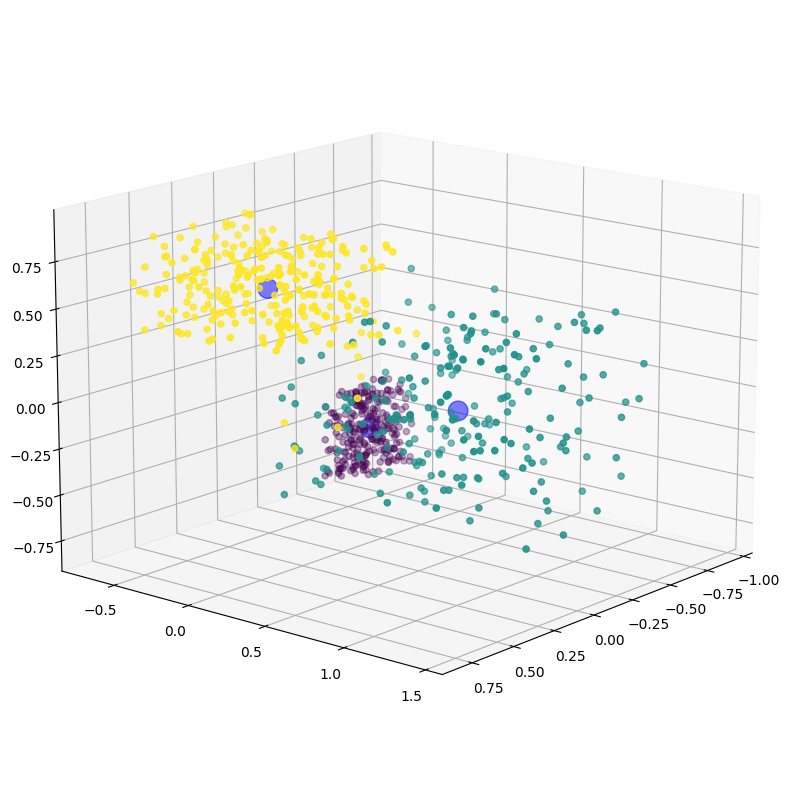

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.view_init(15, 40)

ax.scatter(Xtest[:,0], Xtest[:,1],Xtest[:,3],c=predicted_kmean,cmap='viridis')
ax.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],kmeans.cluster_centers_[:,3],c ='blue',s=200,alpha = 0.5)

plt.show()